N-Beats Example

https://github.com/philipperemy/n-beats/blob/master/examples/NBeats.ipynb

https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line

In [1]:
%matplotlib inline
import os
import sys
sys.path.append('/Users/hayashiyus/jupyter-lab/neural-networks_sandbox/N-Beats/examples')

import numpy as np
import pandas as pd
import torch
from torch import nn,optim
from torch.nn import functional as F
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
plt.style.use('seaborn-colorblind')

from data import get_m4_data, dummy_data_generator
#from nbeats_pytorch.model import NBeatsNet # some import from the trainer script e.g. load/save functions.

CHECKPOINT_NAME = 'nbeats-training-checkpoint.th'

# https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line
# It's a toy example to show how to do time series forecasting using N-Beats.

In [2]:
class NBeatsNet(nn.Module):
    SEASONALITY_BLOCK = 'seasonality'
    TREND_BLOCK = 'trend'
    GENERIC_BLOCK = 'generic'

    def __init__(self,
                 device,
                 stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
                 nb_blocks_per_stack=3,
                 forecast_length=5,
                 backcast_length=10,
                 thetas_dims=(4, 8),
                 share_weights_in_stack=False,
                 hidden_layer_units=256,
                 nb_harmonics=None):
        super(NBeatsNet, self).__init__()
        self.forecast_length = forecast_length
        self.backcast_length = backcast_length
        self.hidden_layer_units = hidden_layer_units
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack
        self.nb_harmonics = nb_harmonics
        self.stack_types = stack_types
        self.stacks = []
        self.thetas_dim = thetas_dims
        self.parameters = []
        self.device = device
        print(f'| N-Beats')
        for stack_id in range(len(self.stack_types)):
            self.stacks.append(self.create_stack(stack_id))
        self.parameters = nn.ParameterList(self.parameters)
        self.to(self.device)

    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        print(f'| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})')
        blocks = []
        for block_id in range(self.nb_blocks_per_stack):
            block_init = NBeatsNet.select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(self.hidden_layer_units, self.thetas_dim[stack_id],
                                   self.device, self.backcast_length, self.forecast_length, self.nb_harmonics)
                self.parameters.extend(block.parameters())
            print(f'     | -- {block}')
            blocks.append(block)
        return blocks

    @staticmethod
    def select_block(block_type):
        if block_type == NBeatsNet.SEASONALITY_BLOCK:
            return SeasonalityBlock
        elif block_type == NBeatsNet.TREND_BLOCK:
            return TrendBlock
        else:
            return GenericBlock

    def forward(self, backcast):
        forecast = torch.zeros(size=(backcast.size()[0], self.forecast_length,))  # maybe batch size here.
        for stack_id in range(len(self.stacks)):
            for block_id in range(len(self.stacks[stack_id])):
                b, f = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - b
                forecast = forecast.to(self.device) + f
        return backcast, forecast


def seasonality_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= thetas.shape[1], 'thetas_dim is too big.'
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = torch.tensor([np.cos(2 * np.pi * i * t) for i in range(p1)]).float()  # H/2-1
    s2 = torch.tensor([np.sin(2 * np.pi * i * t) for i in range(p2)]).float()
    S = torch.cat([s1, s2])
    return thetas.mm(S.to(device))


def trend_model(thetas, t, device):
    p = thetas.size()[-1]
    #assert p <= 4, 'thetas_dim is too big.'
    assert p <= 5, 'thetas_dim is too big.'
    T = torch.tensor([t ** i for i in range(p)]).float()
    return thetas.mm(T.to(device))


def linspace(backcast_length, forecast_length):
    lin_space = np.linspace(-backcast_length, forecast_length, backcast_length + forecast_length)
    b_ls = lin_space[:backcast_length]
    f_ls = lin_space[backcast_length:]
    return b_ls, f_ls


class Block(nn.Module):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, share_thetas=False):
        super(Block, self).__init__()
        self.units = units
        self.thetas_dim = thetas_dim
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.share_thetas = share_thetas
        self.fc1 = nn.Linear(backcast_length, units)
        self.fc2 = nn.Linear(units, units)
        self.fc3 = nn.Linear(units, units)
        self.fc4 = nn.Linear(units, units)
        self.device = device
        self.backcast_linspace, self.forecast_linspace = linspace(backcast_length, forecast_length)
        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
        else:
            self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
            self.theta_f_fc = nn.Linear(units, thetas_dim, bias=False)

    def forward(self, x):
        x = F.relu(self.fc1(x.to(self.device)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

    def __str__(self):
        block_type = type(self).__name__
        return f'{block_type}(units={self.units}, thetas_dim={self.thetas_dim}, ' \
               f'backcast_length={self.backcast_length}, forecast_length={self.forecast_length}, ' \
               f'share_thetas={self.share_thetas}) at @{id(self)}'


class SeasonalityBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        if nb_harmonics:
            super(SeasonalityBlock, self).__init__(units, nb_harmonics, device, backcast_length,
                                                   forecast_length, share_thetas=True)
        else:
            super(SeasonalityBlock, self).__init__(units, forecast_length, device, backcast_length,
                                                   forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(SeasonalityBlock, self).forward(x)
        backcast = seasonality_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = seasonality_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class TrendBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(TrendBlock, self).__init__(units, thetas_dim, device, backcast_length,
                                         forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(TrendBlock, self).forward(x)
        backcast = trend_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = trend_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class GenericBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(GenericBlock, self).__init__(units, thetas_dim, device, backcast_length, forecast_length)

        self.backcast_fc = nn.Linear(thetas_dim, backcast_length)
        self.forecast_fc = nn.Linear(thetas_dim, forecast_length)

    def forward(self, x):
        # no constraint for generic arch.
        x = super(GenericBlock, self).forward(x)

        theta_b = F.relu(self.theta_b_fc(x))
        theta_f = F.relu(self.theta_f_fc(x))

        backcast = self.backcast_fc(theta_b)  # generic. 3.3.
        forecast = self.forecast_fc(theta_f)  # generic. 3.3.

        return backcast, forecast

In [3]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)

# simple batcher.
def data_generator(x_full, y_full, bs):
    def split(arr, size):
        arrays = []
        while len(arr) > size:
            slice_ = arr[:size]
            arrays.append(slice_)
            arr = arr[size:]
        arrays.append(arr)
        return arrays

    while True:
        for rr in split((x_full, y_full), bs):
            yield rr

In [4]:
# trainer
def train_100_grad_steps(data, device, net, optimiser, test_losses):
    global_step = load(net, optimiser)
    for x_train_batch, y_train_batch in data:
        global_step += 1
        optimiser.zero_grad()
        net.train()
        _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(device))
        loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(device))
        loss.backward()
        optimiser.step()
        if global_step % 30 == 0:
            print(f'grad_step = {str(global_step).zfill(6)}, tr_loss = {loss.item():.6f}, te_loss = {test_losses[-1]:.6f}')
        if global_step > 0 and global_step % 100 == 0:
            with torch.no_grad():
                save(net, optimiser, global_step)
            break

In [5]:
# loader/saver for checkpoints.
def load(model, optimiser):
    if os.path.exists(CHECKPOINT_NAME):
        checkpoint = torch.load(CHECKPOINT_NAME)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
        grad_step = checkpoint['grad_step']
        print(f'Restored checkpoint from {CHECKPOINT_NAME}.')
        return grad_step
    return 0

def save(model, optimiser, grad_step):
    torch.save({
        'grad_step': grad_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimiser.state_dict(),
    }, CHECKPOINT_NAME)

In [6]:
# evaluate model on test data and produce some plots.
def eval_test(backcast_length, forecast_length, net, norm_constant, test_losses, x_test, y_test):
    net.eval()
    _, forecast = net(torch.tensor(x_test, dtype=torch.float))
    test_losses.append(F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item())
    p = forecast.detach().numpy()
    subplots = [221, 222, 223, 224]
    plt.figure(1)
    for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
        ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
        plt.subplot(subplots[plot_id])
        plt.grid()
        plot_scatter(range(0, backcast_length), xx, color='b')
        plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
        plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
    plt.show()

In [7]:
# main
if os.path.isfile(CHECKPOINT_NAME):
    os.remove(CHECKPOINT_NAME)
device = torch.device('cpu')  # use the trainer.py to run on GPU.
'''
forecast_length = 5
backcast_length = 3 * forecast_length
batch_size = 10  # greater than 4 for viz
'''
forecast_length = 10
backcast_length = 3 * forecast_length
batch_size = 10  # greater than 4 for viz

milk = pd.read_csv('/Users/hayashiyus/jupyter-lab/neural-networks_sandbox/N-Beats/examples/data/milk.csv', index_col=0, parse_dates=True)

print(milk.head())
milk = milk.values  # just keep np array here for simplicity.
norm_constant = np.max(milk)
milk = milk / norm_constant  # small leak to the test set here.

x_train_batch, y = [], []
for i in range(backcast_length, len(milk) - forecast_length):
    x_train_batch.append(milk[i - backcast_length:i])
    y.append(milk[i:i + forecast_length])

x_train_batch = np.array(x_train_batch)[..., 0]
y = np.array(y)[..., 0]

c = int(len(x_train_batch) * 0.8)
x_train, y_train = x_train_batch[:c], y[:c]
x_test, y_test = x_train_batch[c:], y[c:]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

            milk_production_pounds
month                             
1962-01-01                     589
1962-02-01                     561
1962-03-01                     640
1962-04-01                     656
1962-05-01                     727
(102, 30) (26, 30)
(102, 10) (26, 10)


In [8]:
# model
net = NBeatsNet(stack_types=[NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK],
                #stack_types=[NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK],
                forecast_length=forecast_length,
                thetas_dims=[12, 13],
                #thetas_dims=[4, 12],
                nb_blocks_per_stack=3,
                backcast_length=backcast_length,
                hidden_layer_units=128,
                device=device)

optimiser = optim.Adam(net.parameters())

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=12, backcast_length=30, forecast_length=10, share_thetas=False) at @4794361168
     | -- GenericBlock(units=128, thetas_dim=12, backcast_length=30, forecast_length=10, share_thetas=False) at @4794361056
     | -- GenericBlock(units=128, thetas_dim=12, backcast_length=30, forecast_length=10, share_thetas=False) at @4794361448
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=13, backcast_length=30, forecast_length=10, share_thetas=False) at @4794362008
     | -- GenericBlock(units=128, thetas_dim=13, backcast_length=30, forecast_length=10, share_thetas=False) at @4794362512
     | -- GenericBlock(units=128, thetas_dim=13, backcast_length=30, forecast_length=10, share_thetas=False) at @4794363744


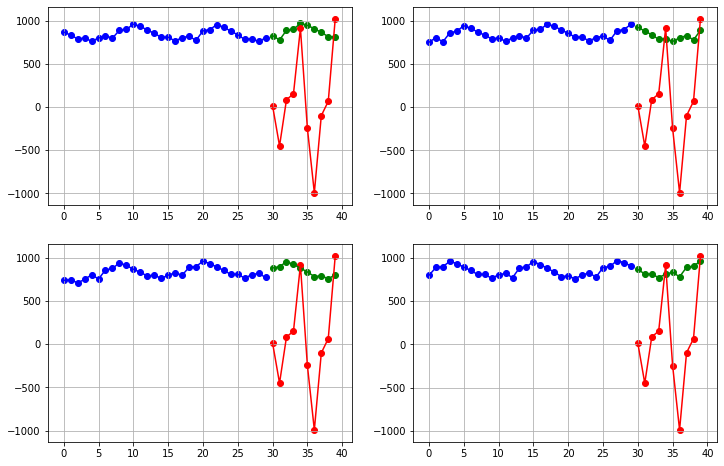

grad_step = 000030, tr_loss = 0.011546, te_loss = 1.032869
grad_step = 000060, tr_loss = 0.005276, te_loss = 1.032869
grad_step = 000090, tr_loss = 0.004721, te_loss = 1.032869


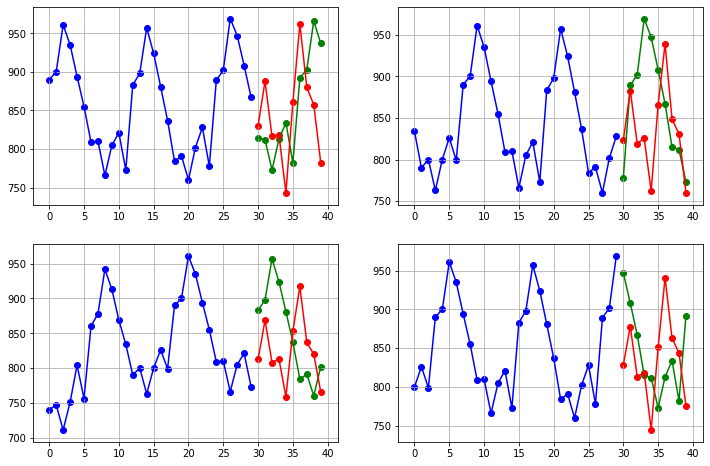

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000120, tr_loss = 0.004223, te_loss = 0.006788
grad_step = 000150, tr_loss = 0.003441, te_loss = 0.006788
grad_step = 000180, tr_loss = 0.002843, te_loss = 0.006788


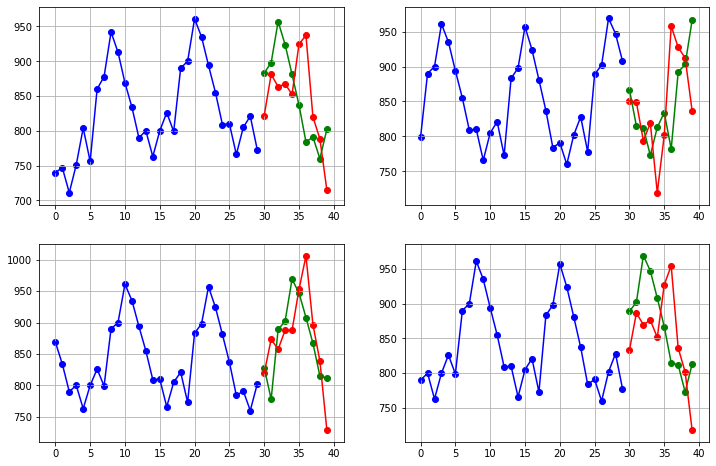

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000210, tr_loss = 0.001953, te_loss = 0.004461
grad_step = 000240, tr_loss = 0.001231, te_loss = 0.004461
grad_step = 000270, tr_loss = 0.000911, te_loss = 0.004461
grad_step = 000300, tr_loss = 0.000767, te_loss = 0.004461


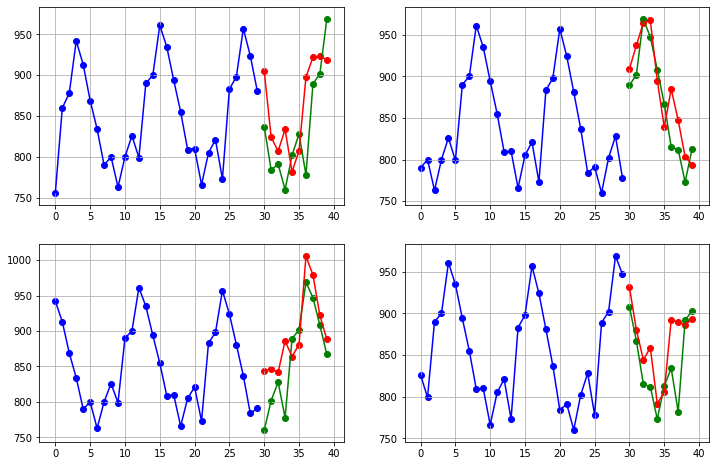

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000330, tr_loss = 0.000674, te_loss = 0.002199
grad_step = 000360, tr_loss = 0.000594, te_loss = 0.002199
grad_step = 000390, tr_loss = 0.000531, te_loss = 0.002199


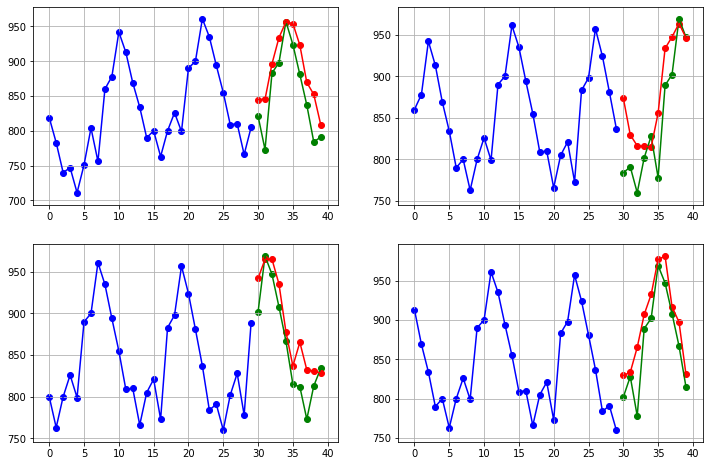

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000420, tr_loss = 0.000485, te_loss = 0.001739
grad_step = 000450, tr_loss = 0.000459, te_loss = 0.001739
grad_step = 000480, tr_loss = 0.000448, te_loss = 0.001739


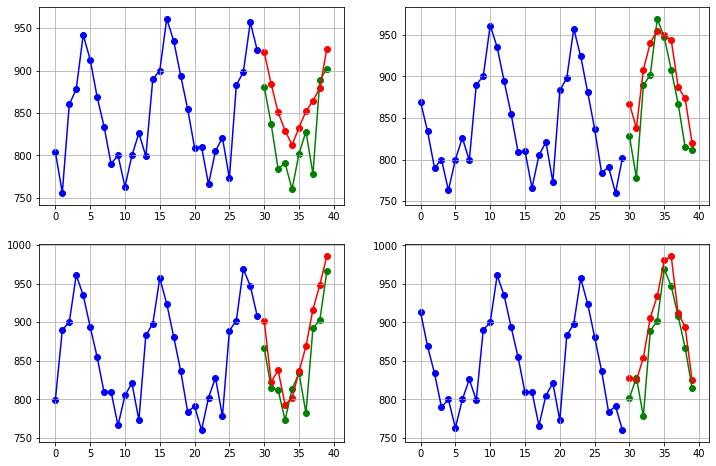

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000510, tr_loss = 0.000434, te_loss = 0.001641
grad_step = 000540, tr_loss = 0.000413, te_loss = 0.001641
grad_step = 000570, tr_loss = 0.000434, te_loss = 0.001641
grad_step = 000600, tr_loss = 0.000403, te_loss = 0.001641


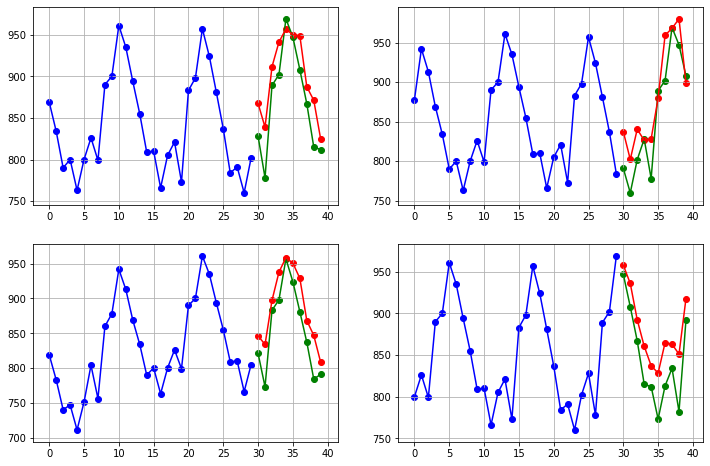

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000630, tr_loss = 0.000392, te_loss = 0.001742
grad_step = 000660, tr_loss = 0.000384, te_loss = 0.001742
grad_step = 000690, tr_loss = 0.000366, te_loss = 0.001742


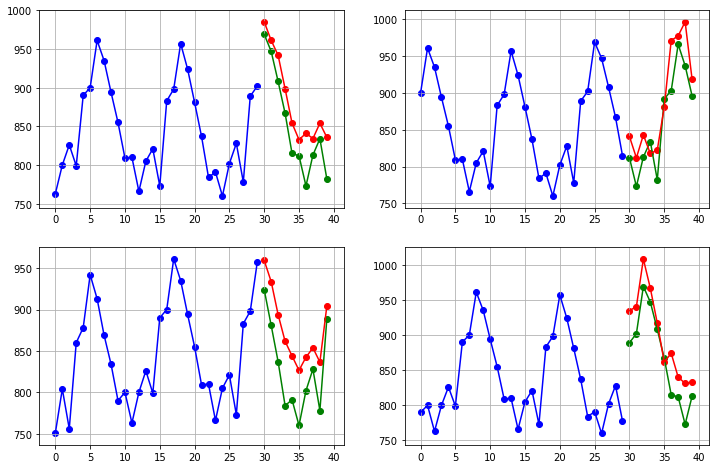

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000720, tr_loss = 0.000356, te_loss = 0.001905
grad_step = 000750, tr_loss = 0.000355, te_loss = 0.001905
grad_step = 000780, tr_loss = 0.000330, te_loss = 0.001905


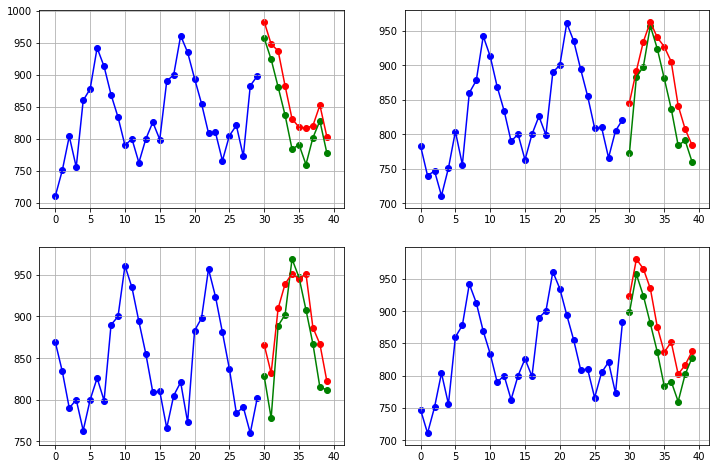

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000810, tr_loss = 0.000332, te_loss = 0.001508
grad_step = 000840, tr_loss = 0.000321, te_loss = 0.001508
grad_step = 000870, tr_loss = 0.000308, te_loss = 0.001508
grad_step = 000900, tr_loss = 0.000319, te_loss = 0.001508


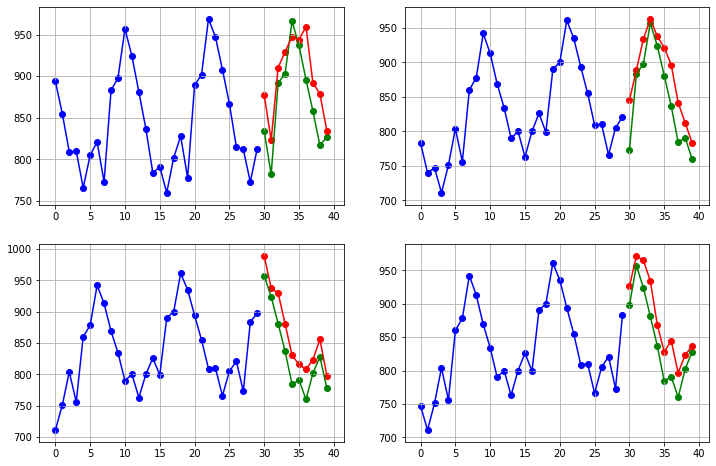

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000930, tr_loss = 0.000296, te_loss = 0.001318
grad_step = 000960, tr_loss = 0.000288, te_loss = 0.001318
grad_step = 000990, tr_loss = 0.000283, te_loss = 0.001318


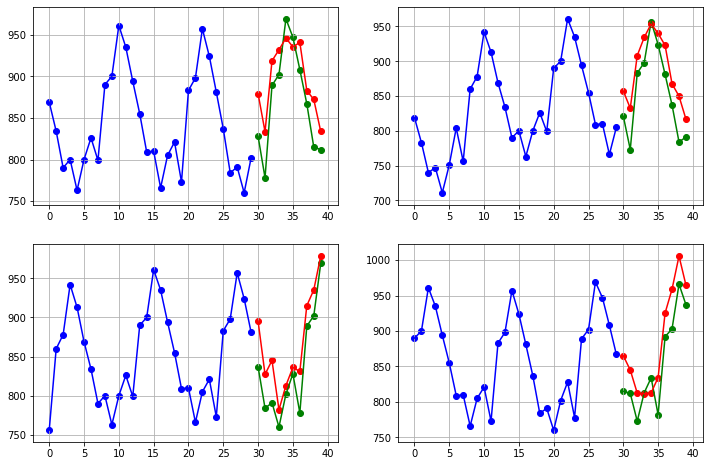

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001020, tr_loss = 0.000272, te_loss = 0.001608
grad_step = 001050, tr_loss = 0.000281, te_loss = 0.001608
grad_step = 001080, tr_loss = 0.000266, te_loss = 0.001608


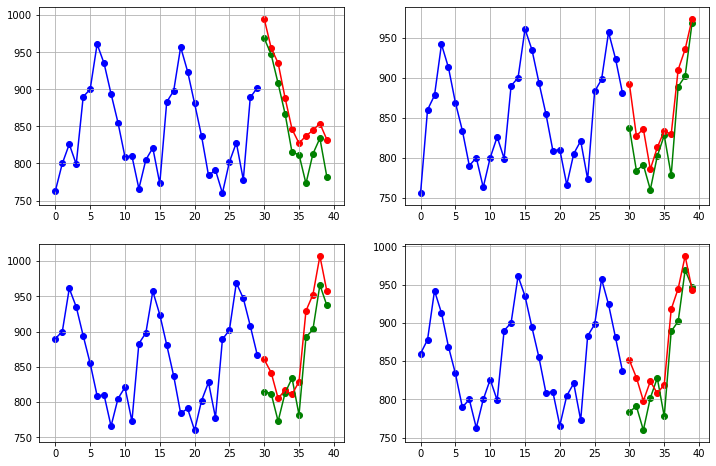

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001110, tr_loss = 0.000266, te_loss = 0.001402
grad_step = 001140, tr_loss = 0.000288, te_loss = 0.001402
grad_step = 001170, tr_loss = 0.000251, te_loss = 0.001402
grad_step = 001200, tr_loss = 0.000263, te_loss = 0.001402


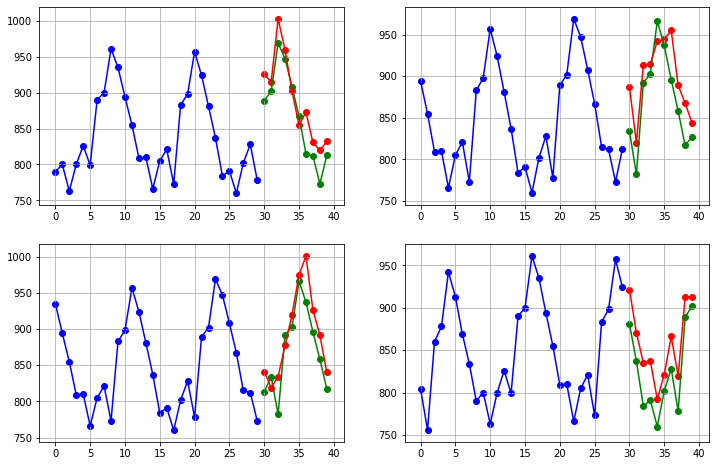

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001230, tr_loss = 0.000237, te_loss = 0.001192
grad_step = 001260, tr_loss = 0.000256, te_loss = 0.001192
grad_step = 001290, tr_loss = 0.000269, te_loss = 0.001192


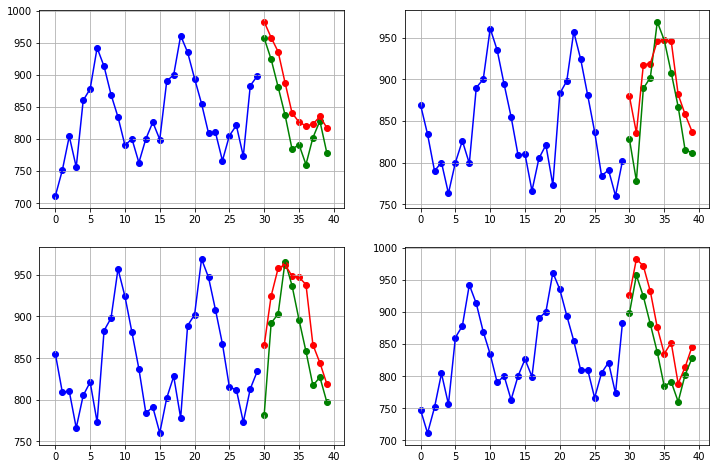

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001320, tr_loss = 0.000235, te_loss = 0.001569
grad_step = 001350, tr_loss = 0.000230, te_loss = 0.001569
grad_step = 001380, tr_loss = 0.000257, te_loss = 0.001569


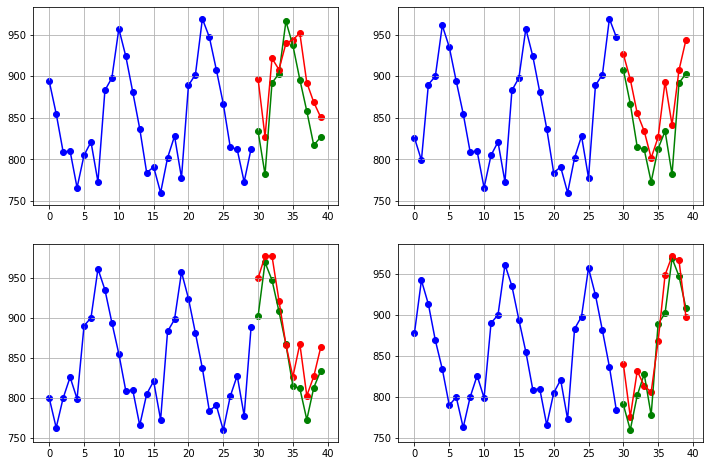

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001410, tr_loss = 0.000215, te_loss = 0.001315
grad_step = 001440, tr_loss = 0.000217, te_loss = 0.001315
grad_step = 001470, tr_loss = 0.000203, te_loss = 0.001315
grad_step = 001500, tr_loss = 0.000201, te_loss = 0.001315


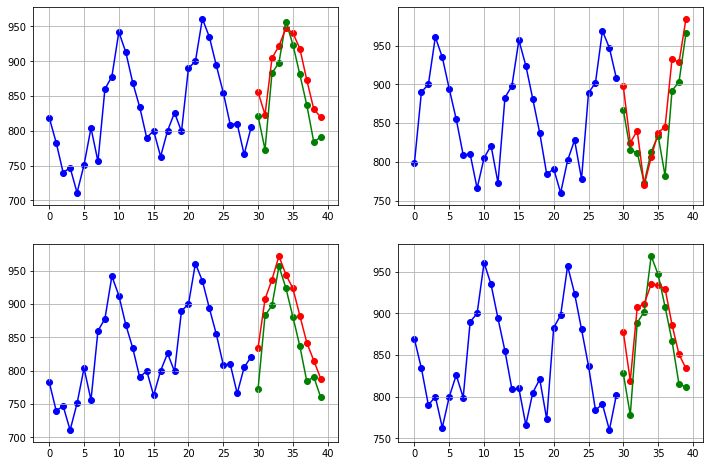

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001530, tr_loss = 0.000191, te_loss = 0.001120
grad_step = 001560, tr_loss = 0.000239, te_loss = 0.001120
grad_step = 001590, tr_loss = 0.000187, te_loss = 0.001120


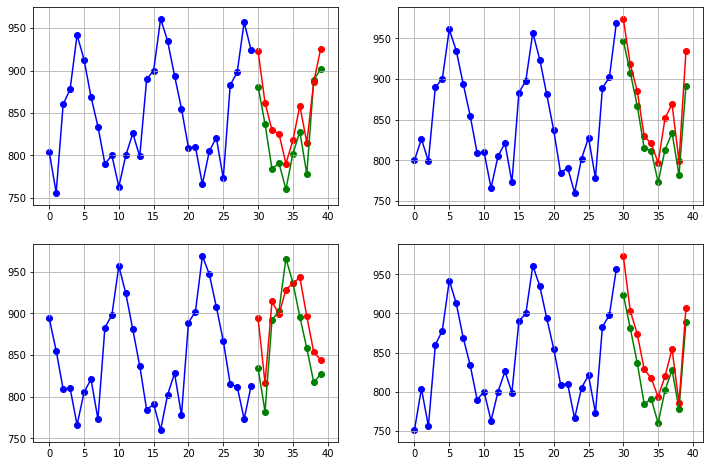

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001620, tr_loss = 0.000183, te_loss = 0.000997
grad_step = 001650, tr_loss = 0.000243, te_loss = 0.000997
grad_step = 001680, tr_loss = 0.000178, te_loss = 0.000997


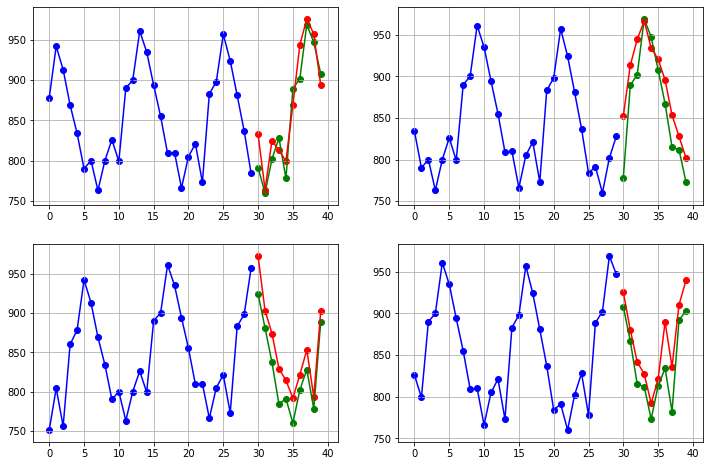

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001710, tr_loss = 0.000194, te_loss = 0.000944
grad_step = 001740, tr_loss = 0.000184, te_loss = 0.000944
grad_step = 001770, tr_loss = 0.000184, te_loss = 0.000944
grad_step = 001800, tr_loss = 0.000168, te_loss = 0.000944


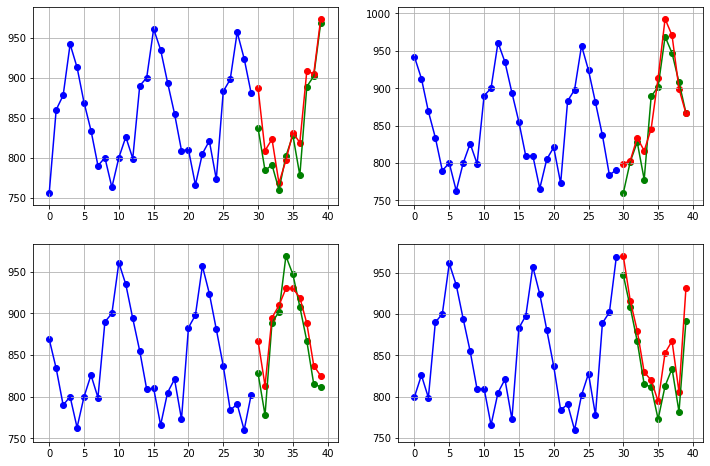

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001830, tr_loss = 0.000187, te_loss = 0.000863
grad_step = 001860, tr_loss = 0.000190, te_loss = 0.000863
grad_step = 001890, tr_loss = 0.000181, te_loss = 0.000863


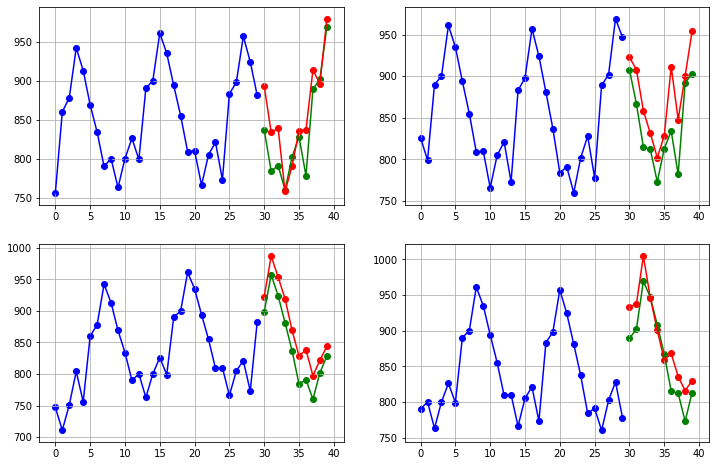

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001920, tr_loss = 0.000159, te_loss = 0.001454
grad_step = 001950, tr_loss = 0.000166, te_loss = 0.001454
grad_step = 001980, tr_loss = 0.000168, te_loss = 0.001454


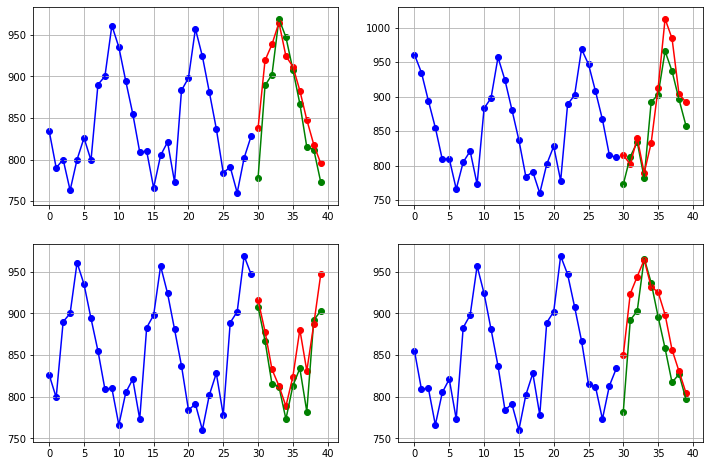

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002010, tr_loss = 0.000144, te_loss = 0.000719
grad_step = 002040, tr_loss = 0.000142, te_loss = 0.000719
grad_step = 002070, tr_loss = 0.000183, te_loss = 0.000719
grad_step = 002100, tr_loss = 0.000148, te_loss = 0.000719


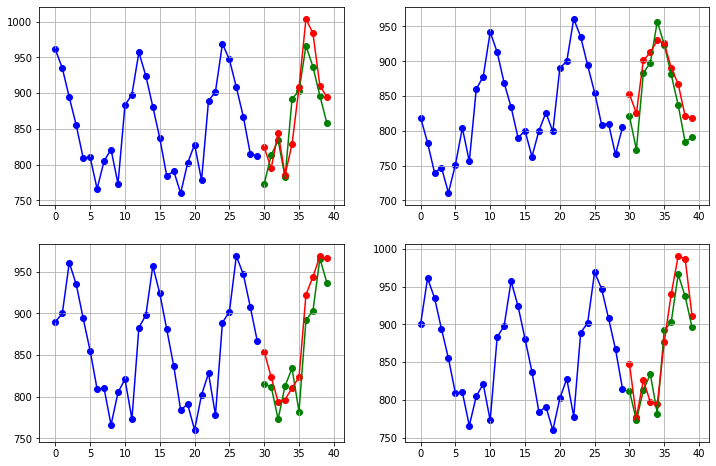

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002130, tr_loss = 0.000205, te_loss = 0.000796
grad_step = 002160, tr_loss = 0.000152, te_loss = 0.000796
grad_step = 002190, tr_loss = 0.000186, te_loss = 0.000796


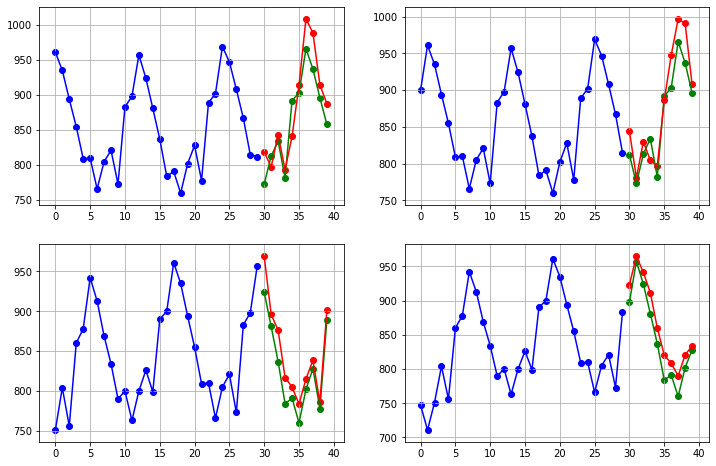

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002220, tr_loss = 0.000320, te_loss = 0.000722
grad_step = 002250, tr_loss = 0.000124, te_loss = 0.000722
grad_step = 002280, tr_loss = 0.000120, te_loss = 0.000722


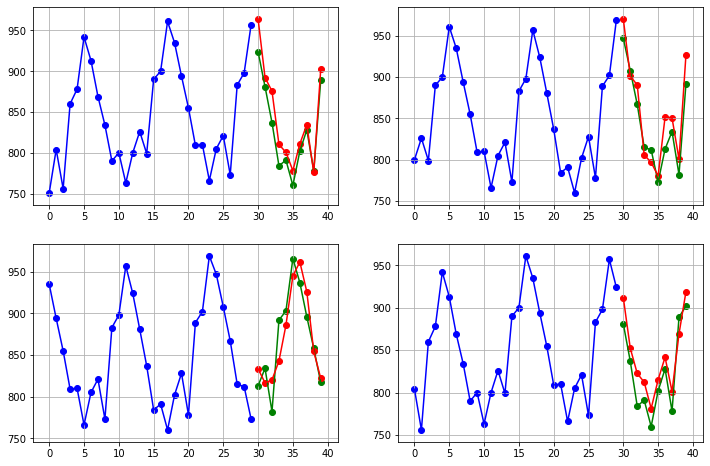

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002310, tr_loss = 0.000150, te_loss = 0.000636
grad_step = 002340, tr_loss = 0.000127, te_loss = 0.000636
grad_step = 002370, tr_loss = 0.000143, te_loss = 0.000636
grad_step = 002400, tr_loss = 0.000128, te_loss = 0.000636


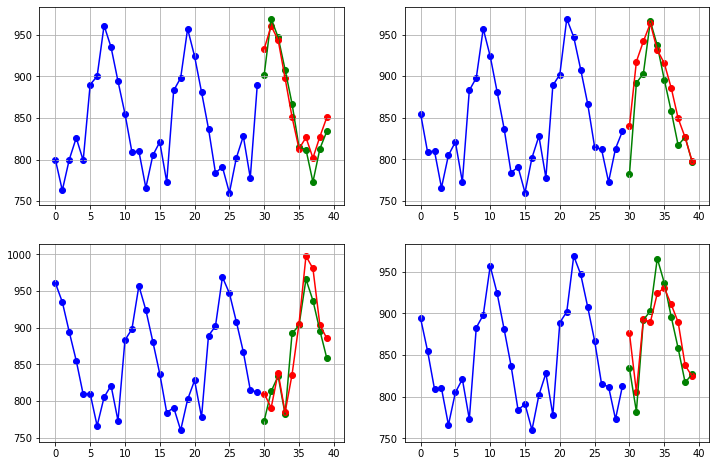

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002430, tr_loss = 0.000186, te_loss = 0.000512
grad_step = 002460, tr_loss = 0.000120, te_loss = 0.000512
grad_step = 002490, tr_loss = 0.000102, te_loss = 0.000512


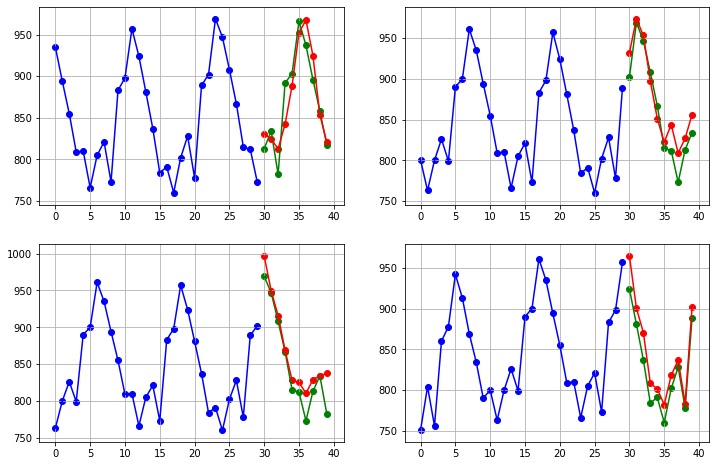

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002520, tr_loss = 0.000108, te_loss = 0.000658
grad_step = 002550, tr_loss = 0.000102, te_loss = 0.000658
grad_step = 002580, tr_loss = 0.000109, te_loss = 0.000658


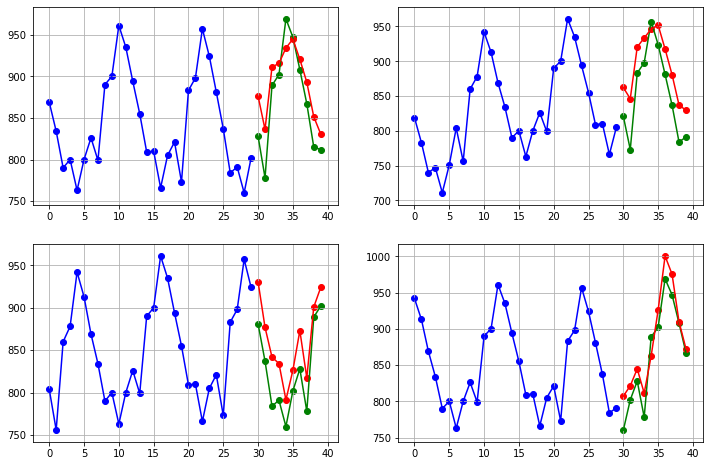

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002610, tr_loss = 0.000124, te_loss = 0.001439
grad_step = 002640, tr_loss = 0.000100, te_loss = 0.001439
grad_step = 002670, tr_loss = 0.000094, te_loss = 0.001439
grad_step = 002700, tr_loss = 0.000211, te_loss = 0.001439


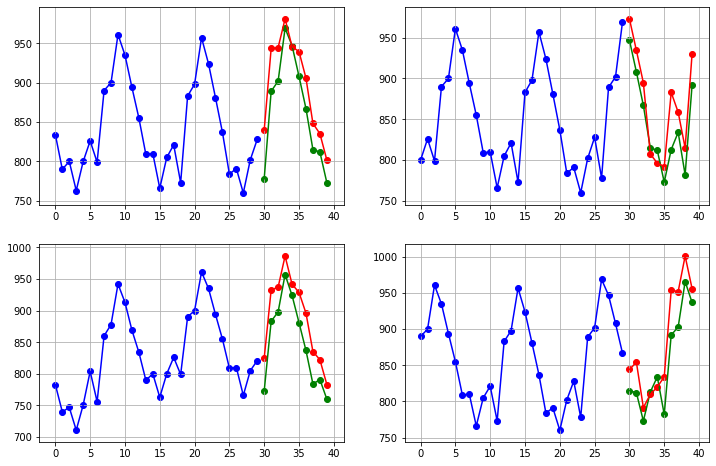

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002730, tr_loss = 0.000089, te_loss = 0.001240
grad_step = 002760, tr_loss = 0.000153, te_loss = 0.001240
grad_step = 002790, tr_loss = 0.000105, te_loss = 0.001240


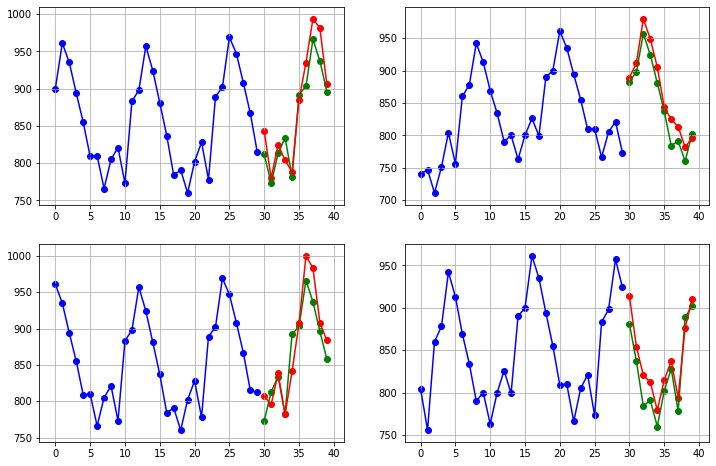

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002820, tr_loss = 0.000117, te_loss = 0.000535
grad_step = 002850, tr_loss = 0.000088, te_loss = 0.000535
grad_step = 002880, tr_loss = 0.000085, te_loss = 0.000535


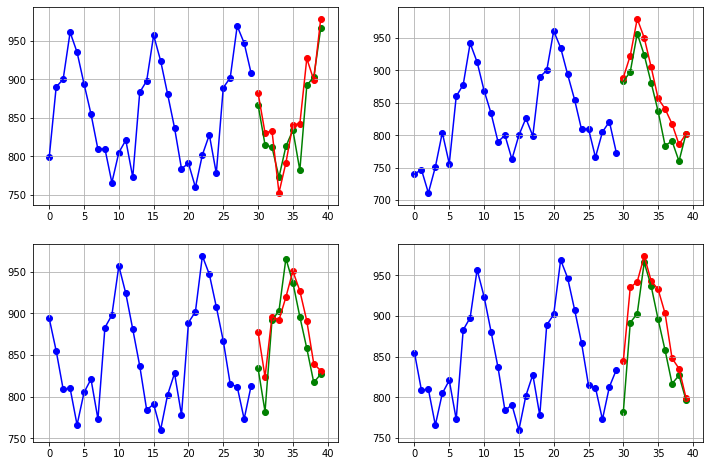

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002910, tr_loss = 0.000091, te_loss = 0.000640
grad_step = 002940, tr_loss = 0.000077, te_loss = 0.000640
grad_step = 002970, tr_loss = 0.000143, te_loss = 0.000640
grad_step = 003000, tr_loss = 0.000084, te_loss = 0.000640


In [9]:
# data
data = data_generator(x_train, y_train, batch_size)

# training
# model seems to converge well around ~2500 grad steps and starts to overfit a bit after.
test_losses = []
for i in range(30):
    rcParams['figure.figsize'] = 12, 8
    eval_test(backcast_length, forecast_length, net, norm_constant, test_losses, x_test, y_test)
    train_100_grad_steps(data, device, net, optimiser, test_losses)